# Exploratory Data Analysis
___

Before diving deep into the analytics set up, we will first examine the essential metrics of the product, understanding their distributions across various user groups, and observing their temporal behaviour.

## Summary and Conclusion:

- Majority of the feed users are between 20-35 years old, with 2/3 using Android app and 60% coming via paid traffic.

- Germany has the majority of the users, and Poland, Belarus, Kazakhstan forming the most of non-German traffic.
- Posts having highest number of views tend to have higher conversions, we can try promotng posts with slightly lower views to increase their CTR.
- Posts 'live' 1-3 days on average, and long-living posts (>5 days) have higher CTR. Similarly, we can promote posts with 3-4 days life to get higher conversions.
- Organic traffic has higher per-user views than the paid one (100-200 VS 50-150 for 50% of users).
- DAU has both 24-hr and 7-day seasonality.
- Active users is peaking at 6-7 PM, with post published peaking at 7-8 PM. Lowest activity is observed for 1-5 AM.



## Major Steps:

### 1. Missing values/duplicates removal
- **Data Checkup**: Is the data coming from the database reliable enough?

### 2. User Demographics
Who is using our service? Which groups should we target and attract more actively?
- **Demographical Analysis**: Breakdown of users by age, gender, OS type, traffic source.

- **Geographical Insights**: Highlight the top countries and cities where users come from.

### 3. Post Interactions
Which posts should we promote more? Which have bettter quality? Which are more represented?
- **Views & Likes Analysis**: 
  - Descriptive statistics, distributions, and QQ-plots for views and likes by post.

  - Distribution of views and likes per post.
- **Engagement Metrics**: 
  - Calculate and analyze Click Through Rate (CTR) for posts.

  - Study post "lifetime" and time intervals before and after a post, examining their distributions and correlations.

### 4. User Engagement
Which user groups have higher activity? Which should be targeted to increase their involvement?
- **Engagement Distribution**: Evaluate the number of posts viewed and liked per user.

- **Engagement Breakdown**: Analyze views, unique posts, and CTR by user, segmented by country, operating system, source, and gender.

### 5. Correlation Analysis
Which age groups should we attract to the product?
- **Age & Engagement**: Investigate the correlation between user age and their engagement levels.

### 6. Time Series Analysis
Especially helpful for further applications: predictive analytics and real-time anomaly detection
- **Daily Activity**: Analyze Daily Active Users (DAU) and the distribution of unique posts throughout a day.

- **Hourly Trends**: Decompose time series to uncover hourly DAU trends and seasonality.
- **User Activity vs. Posts**: Compare the distributions of user activity and posts published within a given day.

---

We start with the necessary imports and parameters

In [1]:
# to hide a database access password
import os
from dotenv import load_dotenv

# database connection - modification of the original pandahouse package
import pandahouse_connector as ph

# data manipulation
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistics-related methods and time series decomposition
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
from statsmodels.tsa.seasonal import STL

In [2]:
# Load environment variables from .env file
load_dotenv(dotenv_path='../.env')

# introduce the secret variable to connect to the db
DA_SL_PWD = os.environ.get('DA_SL_PWD')

# set the connection with the db
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20230720',
    'user':'student', 
    'password':DA_SL_PWD
    }

# define the name of the schema
feed_db = 'simulator_20230720.feed_actions'

## 1. Missing values/duplicates removal

- For each column of the schema, how many missing entries do we have?  

- Are there duplicate entries?


In [3]:
missing_query = \
f"""
-- This query is designed to count the number of missing values for each column.
-- The countIf() function is utilized to count rows where a particular field is NULL.

SELECT
    countIf(user_id IS NULL) AS missing_user_id,     -- Count rows with missing user_id
    countIf(post_id IS NULL) AS missing_post_id,     -- Count rows with missing post_id
    countIf(action IS NULL) AS missing_action,       -- Count rows with missing action
    countIf(time IS NULL) AS missing_time,           -- Count rows with missing time
    countIf(gender IS NULL) AS missing_gender,       -- Count rows with missing gender
    countIf(age IS NULL) AS missing_age,             -- Count rows with missing age
    countIf(country IS NULL) AS missing_country,     -- Count rows with missing country
    countIf(city IS NULL) AS missing_city,           -- Count rows with missing city
    countIf(os IS NULL) AS missing_os,               -- Count rows with missing operating system
    countIf(source IS NULL) AS missing_source,       -- Count rows with missing source
    countIf(exp_group IS NULL) AS missing_exp_group  -- Count rows with missing experiment group
FROM 
    {feed_db};
"""

duplicate_query = \
f"""
-- This query identifies duplicate rows based on user_id, post_id, action, and time columns.
-- The HAVING clause ensures only duplicates (rows appearing more than once) are returned.

SELECT 
    user_id, 
    post_id, 
    action, 
    time, 
    COUNT(*) AS num_duplicates   -- Count of duplicate occurrences
FROM 
    {feed_db}
GROUP BY 
    user_id, 
    post_id, 
    action, 
    time
HAVING 
    COUNT(*) > 1;
"""

In [4]:
# get the dataframes from the database
missing_df = ph.read_clickhouse(query=missing_query, connection=connection)
duplicate_df = ph.read_clickhouse(query=duplicate_query, connection=connection)

In [5]:
# look at the dimensions - how many rows are in the tables?
missing_df.shape, duplicate_df.shape

((1, 11), (7, 5))

It looks like there are duplicated entries (# rows > 1), let's have a look.

In [6]:
duplicate_df.head(10)

,user_id,post_id,action,time,num_duplicates
0,53783,3698,view,2023-07-23 14:23:36,2
1,31883,2272,view,2023-07-04 14:29:00,2
2,50029,5911,view,2023-08-24 14:04:53,2
3,110566,4836,view,2023-08-06 21:54:21,2
4,96062,6500,view,2023-08-31 22:24:00,2
5,155617,4000,view,2023-07-28 08:39:53,2
6,147037,4306,view,2023-07-30 23:19:02,2


We have 7 duplicate rows, however, it seems that they represent the false-positive cases - a user quickly scrolled through the posts and viewed 2 posts per one second.   

Alright, we have clean data - no missing values and duplicates.  
Now to the next step, overiew and descriptive statistics of the data.

## 2. User Demographics

Let's look at the active feed users for past 30 days (to get a recent cohort) and their composition with regards to:
- Age

- Gender
- OS type (iOS/Android)
- Source (ads/organic traffic)
- Country/city

In [7]:
user_composition_query = \
    f"""
    -- This query retrieves unique user details from the table for the past 30 days.

    SELECT DISTINCT 
        user_id, 
        gender, 
        os,
        source, 
        age, 
        country, 
        city
    FROM 
        {feed_db}
    WHERE 
        toDate(time) BETWEEN toDate(now()) - 30 AND toDate(now())        
    """

# get the dataframe
user_composition_df = ph.read_clickhouse(query=user_composition_query, connection=connection)

In [8]:
user_composition_df.head()

,user_id,gender,os,source,age,country,city
0,58594,1,Android,ads,20,Germany,Hamburg
1,115816,1,Android,organic,22,Germany,Shelekhov
2,118156,1,iOS,organic,38,Germany,Sylva
3,123813,1,Android,organic,39,Germany,Bielefeld
4,148606,1,iOS,organic,17,Germany,Zheleznogorsk


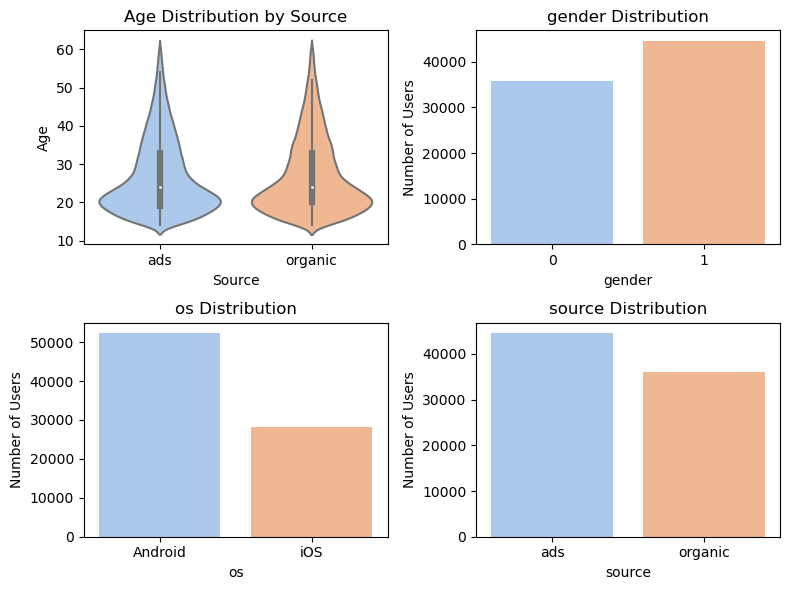

In [9]:
# Setting the figure size
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

# discard the users above 60 to have shorter (and better resolved) violinplot
age_mask = user_composition_df['age'] <= 60

# Violin plots of user age for two genders
sns.violinplot(x='source', y='age', data=user_composition_df[age_mask], palette='pastel', ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution by Source')
axes[0, 0].set_xlabel('Source')
axes[0, 0].set_ylabel('Age')

# arrat to iterate through for plotting
X = ['gender', 'os', 'source']

# iterate through columns and build barplots to see user composition
for x, ax in zip(X, axes.reshape(-1)[1:]):
    sns.countplot(x=x, data=user_composition_df, palette='pastel', ax=ax)
    ax.set_title(f'{x} Distribution')
    ax.set_xlabel(x)
    ax.set_ylabel('Number of Users')

# Adjust layout for better presentation
plt.tight_layout()

- Our most represented active group consists of young people approximately 20-35 y.o.

- Roughly 2/3 of the users log in via Android, and about 60% come via paid traffic.

This information, together with the data of the activity of each group, can be used for further targeting campaigns to increase quality and number of active users.

- There is a slight disbalance gender-wise, which may also be useful for targeting.

- Age represenation of two traffic sources is essentially the same.

Now see the representation of the users by countries and cities.  
As Germany comprises the most of the traffic, let's look at two distributions: including and excluding this country users.

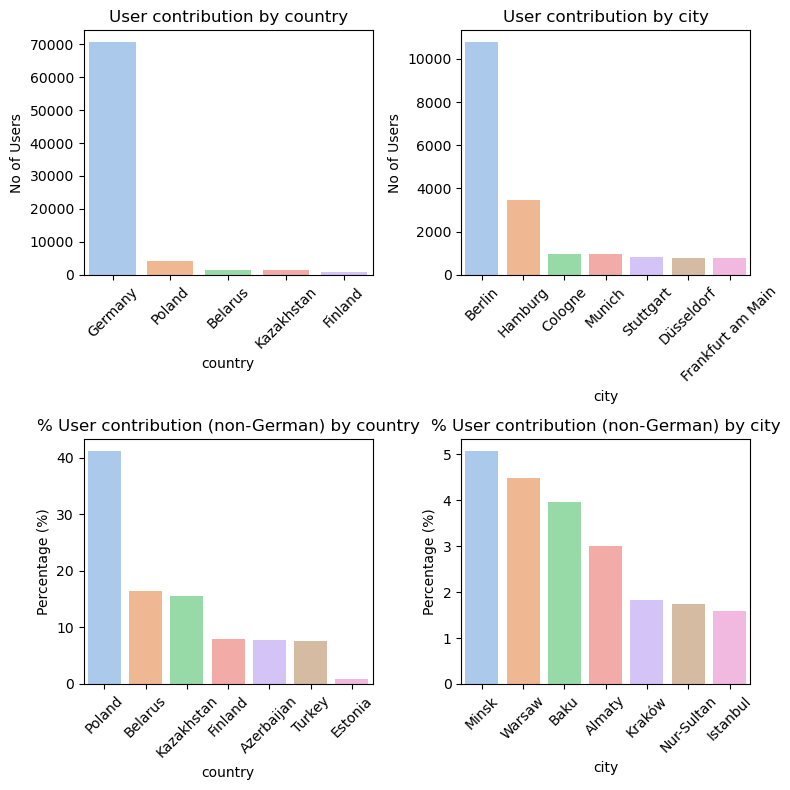

In [10]:
# Filtering data for non-top count country (Germany in this case)
user_composition_df_second = user_composition_df[user_composition_df['country'] != 'Germany']

# make ordered series where total contribution is normalized to 100%
country_distribution = user_composition_df_second['country'].value_counts(normalize=True).head(7) * 100
city_distribution = user_composition_df_second['city'].value_counts(normalize=True).head(7).mul(100)

# a list of dataframes/series to iterate through for plotting
dfs_to_plot = [
    user_composition_df.groupby('country')['user_id'].count().sort_values(ascending=False).head(),
    user_composition_df.groupby('city')['user_id'].count().sort_values(ascending=False).head(7),
    country_distribution,
    city_distribution
]

# make lists with labels/titles for plotting
ylabels = ['No of Users', 'No of Users', "Percentage (%)", "Percentage (%)"]

titles = [
    'User contribution by country', 
    'User contribution by city', 
    '% User contribution (non-German) by country', 
    '% User contribution (non-German) by city'
    ]

# Setting the figure size
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

# iterate and plot
for df, ax, title, ylabel in zip(
                                dfs_to_plot, 
                                axes.flatten(),
                                titles,
                                ylabels):

    # Plotting
    sns.barplot(x=df.index, y=df.values, palette='pastel', ax=ax)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()

- We may try to target users from Colonge, Munich, Frankfurt, and Hanover to increase the flow of German users.

- Poland, Belarus, and Kazakhstan make up to 70% of the non-german traffic. If we want to expand into more countries, we should look at these locations first.


## 3. Post Interactions

Let's now have a look more at the posts:
- likes and views per post - distributions compared, relationship between the metrics;

- CTR by post and post lifetime - any correlation with likes and views? 


In [11]:
# SQL Query for EDA:
# 1. Group by post_id
# 2. Count 'view' and 'like' actions
# 3. Calculate Click-Through Rate (CTR) 
# 4. Calculate the post's lifetime in days

post_eda_query = f'''
    SELECT 
        toString(post_id) AS post_id,
        COUNT(action) FILTER (WHERE action = 'view') AS views, 
        COUNT(action) FILTER (WHERE action = 'like') AS likes,
        likes * 100 / views AS ctr,
        dateDiff('second', min(time), max(time)) / 3600 / 24 AS post_life_days
    FROM {feed_db}
    GROUP BY post_id
    ORDER BY views DESC, likes DESC
'''

# Import query results into a DataFrame and display the top rows
post_eda_df = ph.read_clickhouse(post_eda_query, connection=connection)
post_eda_df.head()


,post_id,views,likes,ctr,post_life_days
0,3129,118637,32703,27.565599,9.258160
1,4844,102434,30849,30.115977,6.909225
2,3120,99332,26791,26.971167,8.395544
3,2936,96439,26306,27.277346,8.670590
4,4188,93790,27583,29.409319,6.566632


In [12]:
post_eda_df.describe() # descript. stat. for likes, views, and lifetimes

,views,likes,ctr,post_life_days
count,7027.000000,7027.000000,7027.000000,7027.000000
mean,7881.102177,1659.710972,13.698267,1.714624
std,12387.175845,3238.049993,6.082221,1.421365
min,1.000000,0.000000,0.000000,0.000000
25%,575.500000,52.000000,9.331231,0.592500
50%,2900.000000,367.000000,12.690355,1.343681
75%,9615.000000,1647.500000,17.692237,2.496950
max,118637.000000,32703.000000,50.000000,9.258160


- Most of the posts have less than 10K views and 2K likes per post, CTR being below 20%.  

- For most of the metrics, there are high-shooting outliers (e.g. posts with 100K views).  

Now to the distributions of the metrics - separately and their comparison with QQ-plots.

In [13]:
# Let`s create the z-transformed views and likes columns -
# easier to compare distributions with a QQ-plot:

# make aliases
views = post_eda_df['views']
likes = post_eda_df['likes']

# make z-score columns
post_eda_df.loc[:, 'views_z'] = views.sub(views.mean()).div(views.std())
post_eda_df.loc[:, 'likes_z'] = likes.sub(likes.mean()).div(likes.std())

# to each row of views, add a label showing its quartile
post_eda_df['views_quartile'] = pd.qcut(post_eda_df['views'], q=4, labels=False)

In [14]:
post_eda_df.head()

,post_id,views,likes,ctr,post_life_days,views_z,likes_z,views_quartile
0,3129,118637,32703,27.565599,9.258160,8.941174,9.587032,3
1,4844,102434,30849,30.115977,6.909225,7.633128,9.014465,3
2,3120,99332,26791,26.971167,8.395544,7.382708,7.761242,3
3,2936,96439,26306,27.277346,8.670590,7.149160,7.611460,3
4,4188,93790,27583,29.409319,6.566632,6.935309,8.005833,3


In [15]:
# let`s look at the distribution of views, likes, their box-plots, 
# QQ-plot of views vs likes, and scatter of views vs likes

def compare_two_distr(data, distr1, distr2, hue=None, num_bins=20):
    
    label1, label2 = distr1.name, distr2.name
    
    fig, axs = plt.subplots(2, 3, figsize=(16, 10)) # canvas creation and sizing

    # Create histograms with annotations
    for i, (distribution, label) in enumerate([(distr1, label1), (distr2, label2)]):
        ax = axs[i, 0]
        sns.histplot(distribution, ax=ax, bins=num_bins)
        ax.set_title(f'distribution of {label}')
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

    # Create boxplots
    for i, (distribution, label) in enumerate([(distr1, label1), (distr2, label2)]):
        ax = axs[i, 1]
        sns.boxplot(data=distribution, ax=ax)
        ax.set_title(label)

    # Create QQ plot
    qqplot_2samples(
        distr1, 
        distr2, 
        xlabel=f'quantiles of {label1}',
        ylabel=f'quantiles of {label2}',
        ax=axs[0, 2], 
        line='45') # Create the QQ-plot
    axs[0, 2].set_title(f'QQ plot: {label1} vs {label2}')

    if data is not None:
        # Create scatter plot with annotations
        ax = axs[1, 2]
        sns.scatterplot(
            data=data, 
            x=f'{label1}', 
            y=f'{label2}', 
            hue=hue, 
            palette=['red', 'green', 'blue', 'magenta'], 
            ax=ax,
            s=3
        )
        ax.set_title(f'{label1} vs {label2}')

    plt.tight_layout()

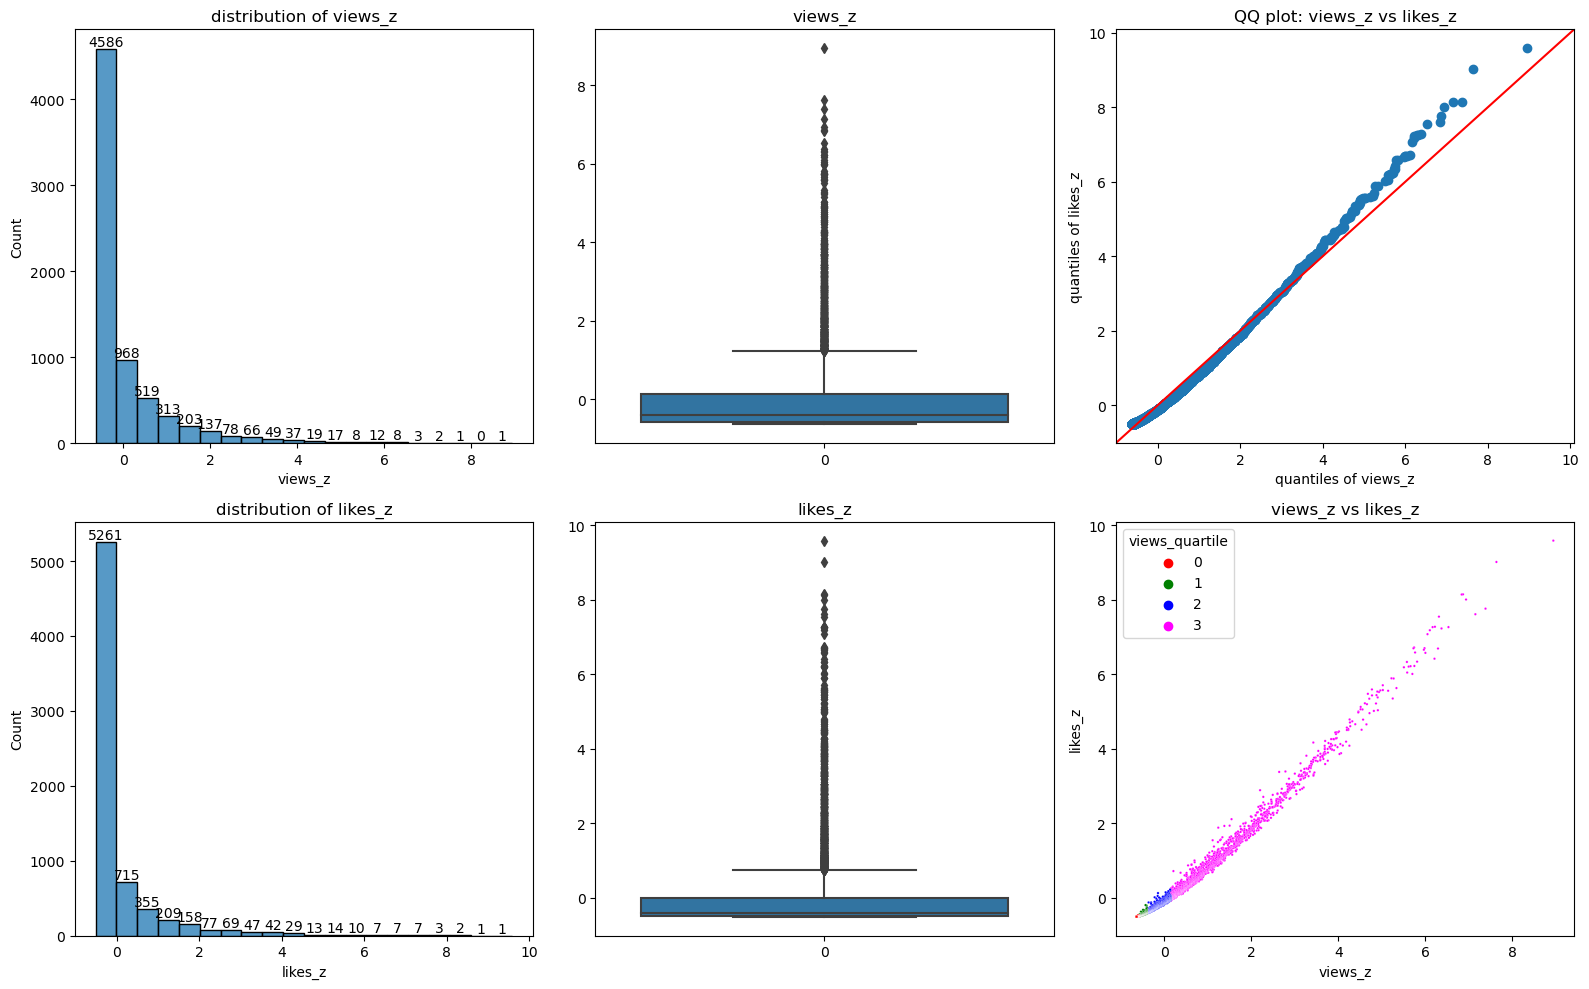

In [16]:
compare_two_distr(post_eda_df, post_eda_df.views_z, post_eda_df.likes_z, hue='views_quartile')

- The two metrics are exponentially distributed;  
- At the top quantiles, we can see that likes are more represented relative to views than in lower quantiles - in other words, posts with large amount of views seem to be more likely to be liked by users (synergetic effect);  We can use this to better promote hot-viewed posts to get higher conversions.

- No clear subgroups on the scatterplot;  
- The metrics are peaking at low values (around -.5 in z-scale) - a lot of 'grey' posts with almost zero views.  

Now to the CTR (likes / views) per post and post lifetime (time of last action - time of first action) vizualization and correlation with views and likes.


In [17]:
# leave only the columns we`d like to compare

metrics_list = [
    'post_life_days',
    'views_z',
    'likes_z',
    'ctr'
        ]

post_eda_df_filtered = post_eda_df[metrics_list]

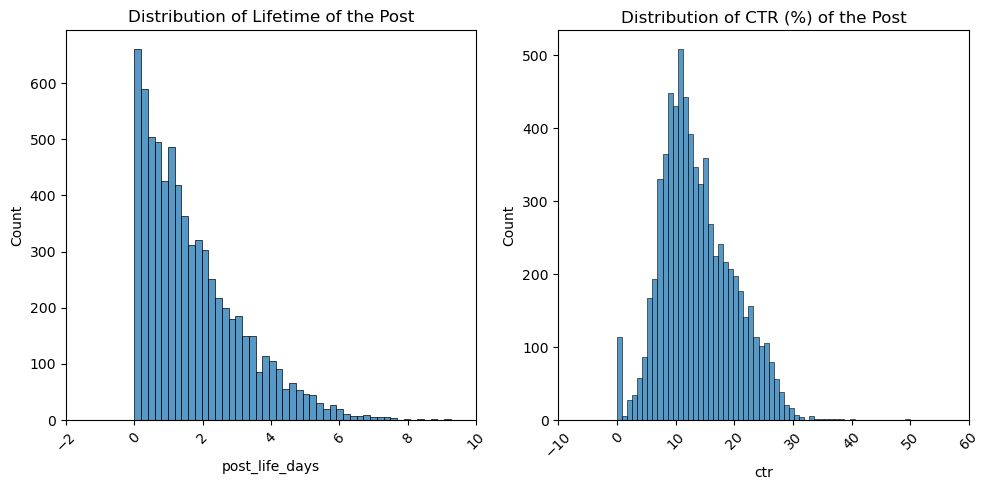

In [18]:
# let`s plot distributions of post lifetime and ctr
fig, axs = plt.subplots(1, 2, figsize=(10, 5)) # canvas creation

# arrays with titles and metrics to iterate through for plotting
titles = [
    'Lifetime of the Post',
    'CTR (%) of the Post'
]

metrics_to_plot = [
    'post_life_days',
    'ctr'
]

for metric, title, ax in zip(metrics_to_plot, titles, axs.flatten()):

    sns.histplot(post_eda_df_filtered[metric], ax=ax)
    ax.set_title(f'Distribution of {title}')
    ax.get_xticklabels()
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.tight_layout()

- Post lifetime, as expected, follows exponential distribution, with the majority of the posts grouped at 1-3 days life.  

- CTR seems to be closer to being normal, yet has longer tail towards the larger values - there are 'outliers' having larger CTR than usual
- There is also a group of almost 0 % CTR posts - probably newly created ones which were not liked yet.

---
How do the metrics relate to each other? Look at the correlation matrix and scatterplots.

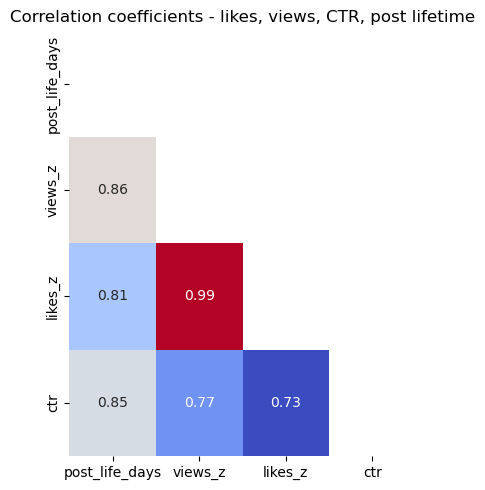

In [19]:
# set figure params
plt.figure(figsize=(4, 5))

plt.title('Correlation coefficients - likes, views, CTR, post lifetime')

# Create a correlation matrix for the filtered series and plot a heatmap
corr_matrix = post_eda_df_filtered.corr()

# Create a mask (matrix with bool values) to hide the upper diagonal part of the matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot a correlation heatmap with masked upper diagonal
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            mask=mask,
            cbar=False);
plt.tight_layout()

- the most correlating pair is views - likes (makes sense)

- for post lifetime, views and ctr have the highest correlation.

How do the relationships look like? Let's see the scatterplots.

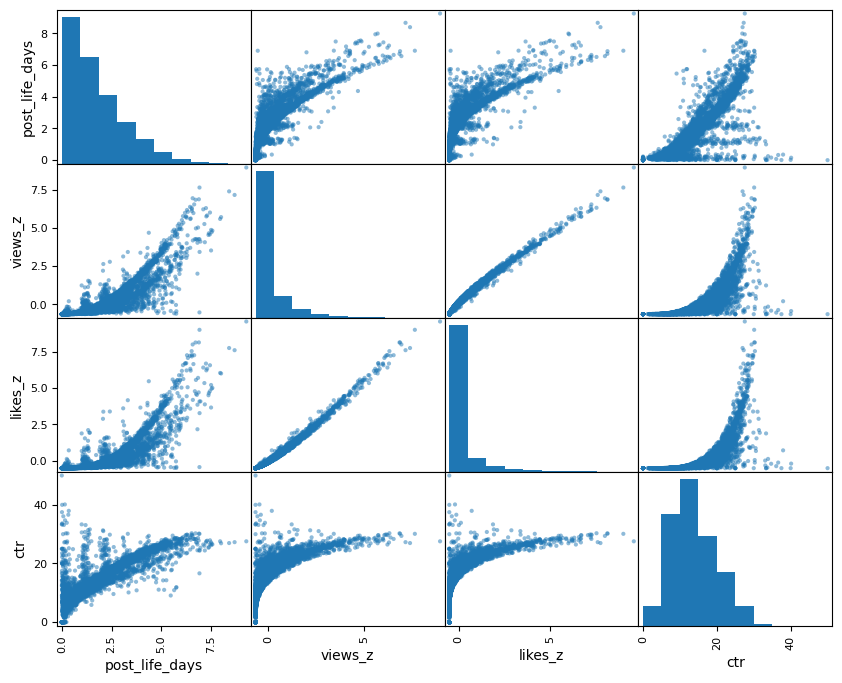

In [20]:
pd.plotting.scatter_matrix(
    post_eda_df_filtered, 
    figsize=(10, 8)
    );

- As we can see, posts with longer lifetime tend to have higher CTRs (although with some saturation - CTR effectively does not grow after about 5 days of lifetime). It could be that they initially have better quality which is a reason for their persistence. 5 days can be set as quality threshold - since these posts are having highest click rating, we can stimulate their authors and promote them to post more.  

- There is saturation in CTR in respect to views - at some point (around 2 in z-scale), there is basically no growth in CTR whilst views are still growing. We can set a views threshold so that the posts are not shown more intensively after this point. Instead, we can try promoting other posts with lower views - it can be that we can saturate them as well, having more posts with high CTR.




## 4. User Engagement

Let's now first see how views and unique posts viewed per user are distributed and then look at per-user metrics (views, unqiue posts, CTR) in respect to country, operating system, source, and gender of users.  
Choose time range to 30 last days, as our feed has been already well established to this point.

In [21]:
# SQL Query to perform exploratory data analysis on users:
# Steps:
# 1. Group by different user attributes.
# 2. Calculate counts of 'view' actions, count of unique posts, and the CTR.
# 3. Filter data to only include records from the past 30 days.

user_eda_query = f'''
    SELECT 
        toString(user_id) AS user_id,
        age,
        country,
        os,
        gender,
        source,
        countIf(action = 'view') AS views,
        count(DISTINCT post_id) AS unique_posts,
        countIf(action = 'like') * 100 / countIf(action = 'view') AS ctr
    FROM {feed_db}
    WHERE toDate(time) BETWEEN toDate(now()) - 30 AND toDate(now())
    GROUP BY 
        user_id,
        age,
        country,
        os,
        gender,
        source
'''

# Import the results of the SQL query into a DataFrame
user_eda_df = ph.read_clickhouse(user_eda_query, connection=connection)

# Grouping 'Germany' as a standalone category and others as 'non-Germany'
mask_germany = user_eda_df['country'] == 'Germany'
user_eda_df.loc[~mask_germany, 'country'] = 'non-Germany'

# Display the top rows of the DataFrame
user_eda_df.head()

,user_id,age,country,os,gender,source,views,unique_posts,ctr
0,80893,21,Germany,Android,1,ads,37,33,13.513514
1,6786,22,Germany,Android,1,ads,25,25,56.000000
2,20405,23,Germany,iOS,0,ads,43,38,13.953488
3,97767,29,Germany,Android,1,ads,48,37,25.000000
4,20378,23,Germany,iOS,1,ads,18,18,27.777778


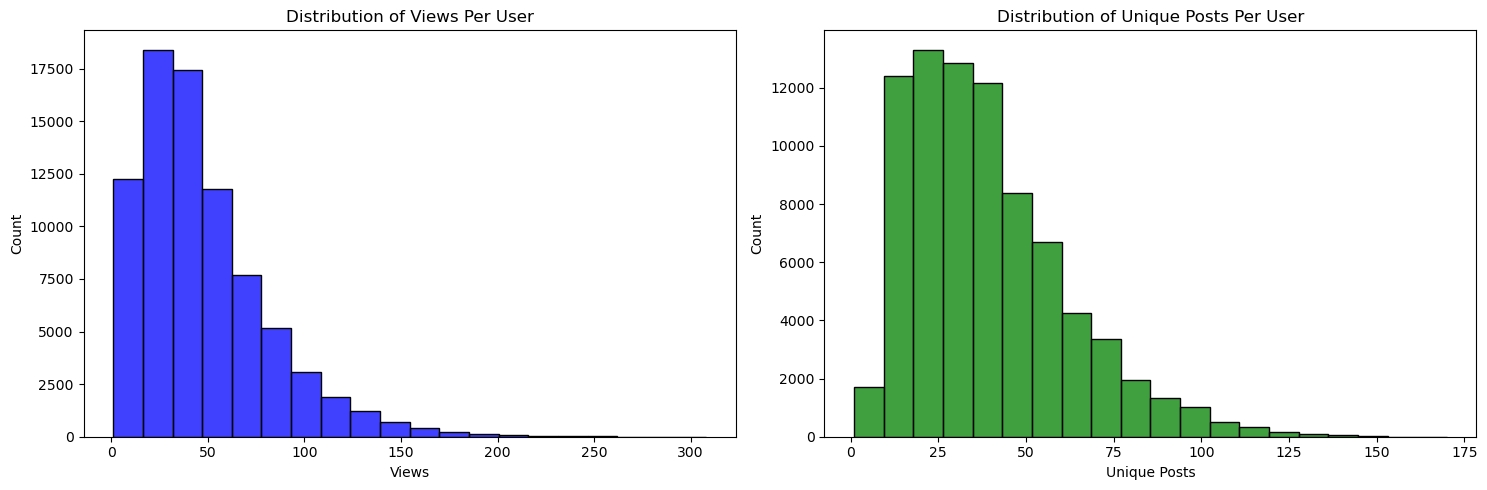

In [22]:
# Setting the figure size
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plotting distribution of views
sns.histplot(user_eda_df['views'], bins=20, ax=axes[0], color='blue')
axes[0].set_title("Distribution of Views Per User")
axes[0].set_xlabel("Views")

# Plotting distribution of unique_posts
sns.histplot(user_eda_df['unique_posts'], bins=20, ax=axes[1], color='green')
axes[1].set_title("Distribution of Unique Posts Per User")
axes[1].set_xlabel("Unique Posts")

plt.tight_layout()

As we see, majority of the users have 50-200 views and 50-150 unique views of the posts per 30 days. The distributions are not symmetrical - there are tails towards larger values, indicating there is a portion of very active users.  

Do these active users belong to some specific groups? Let's split the users and see.


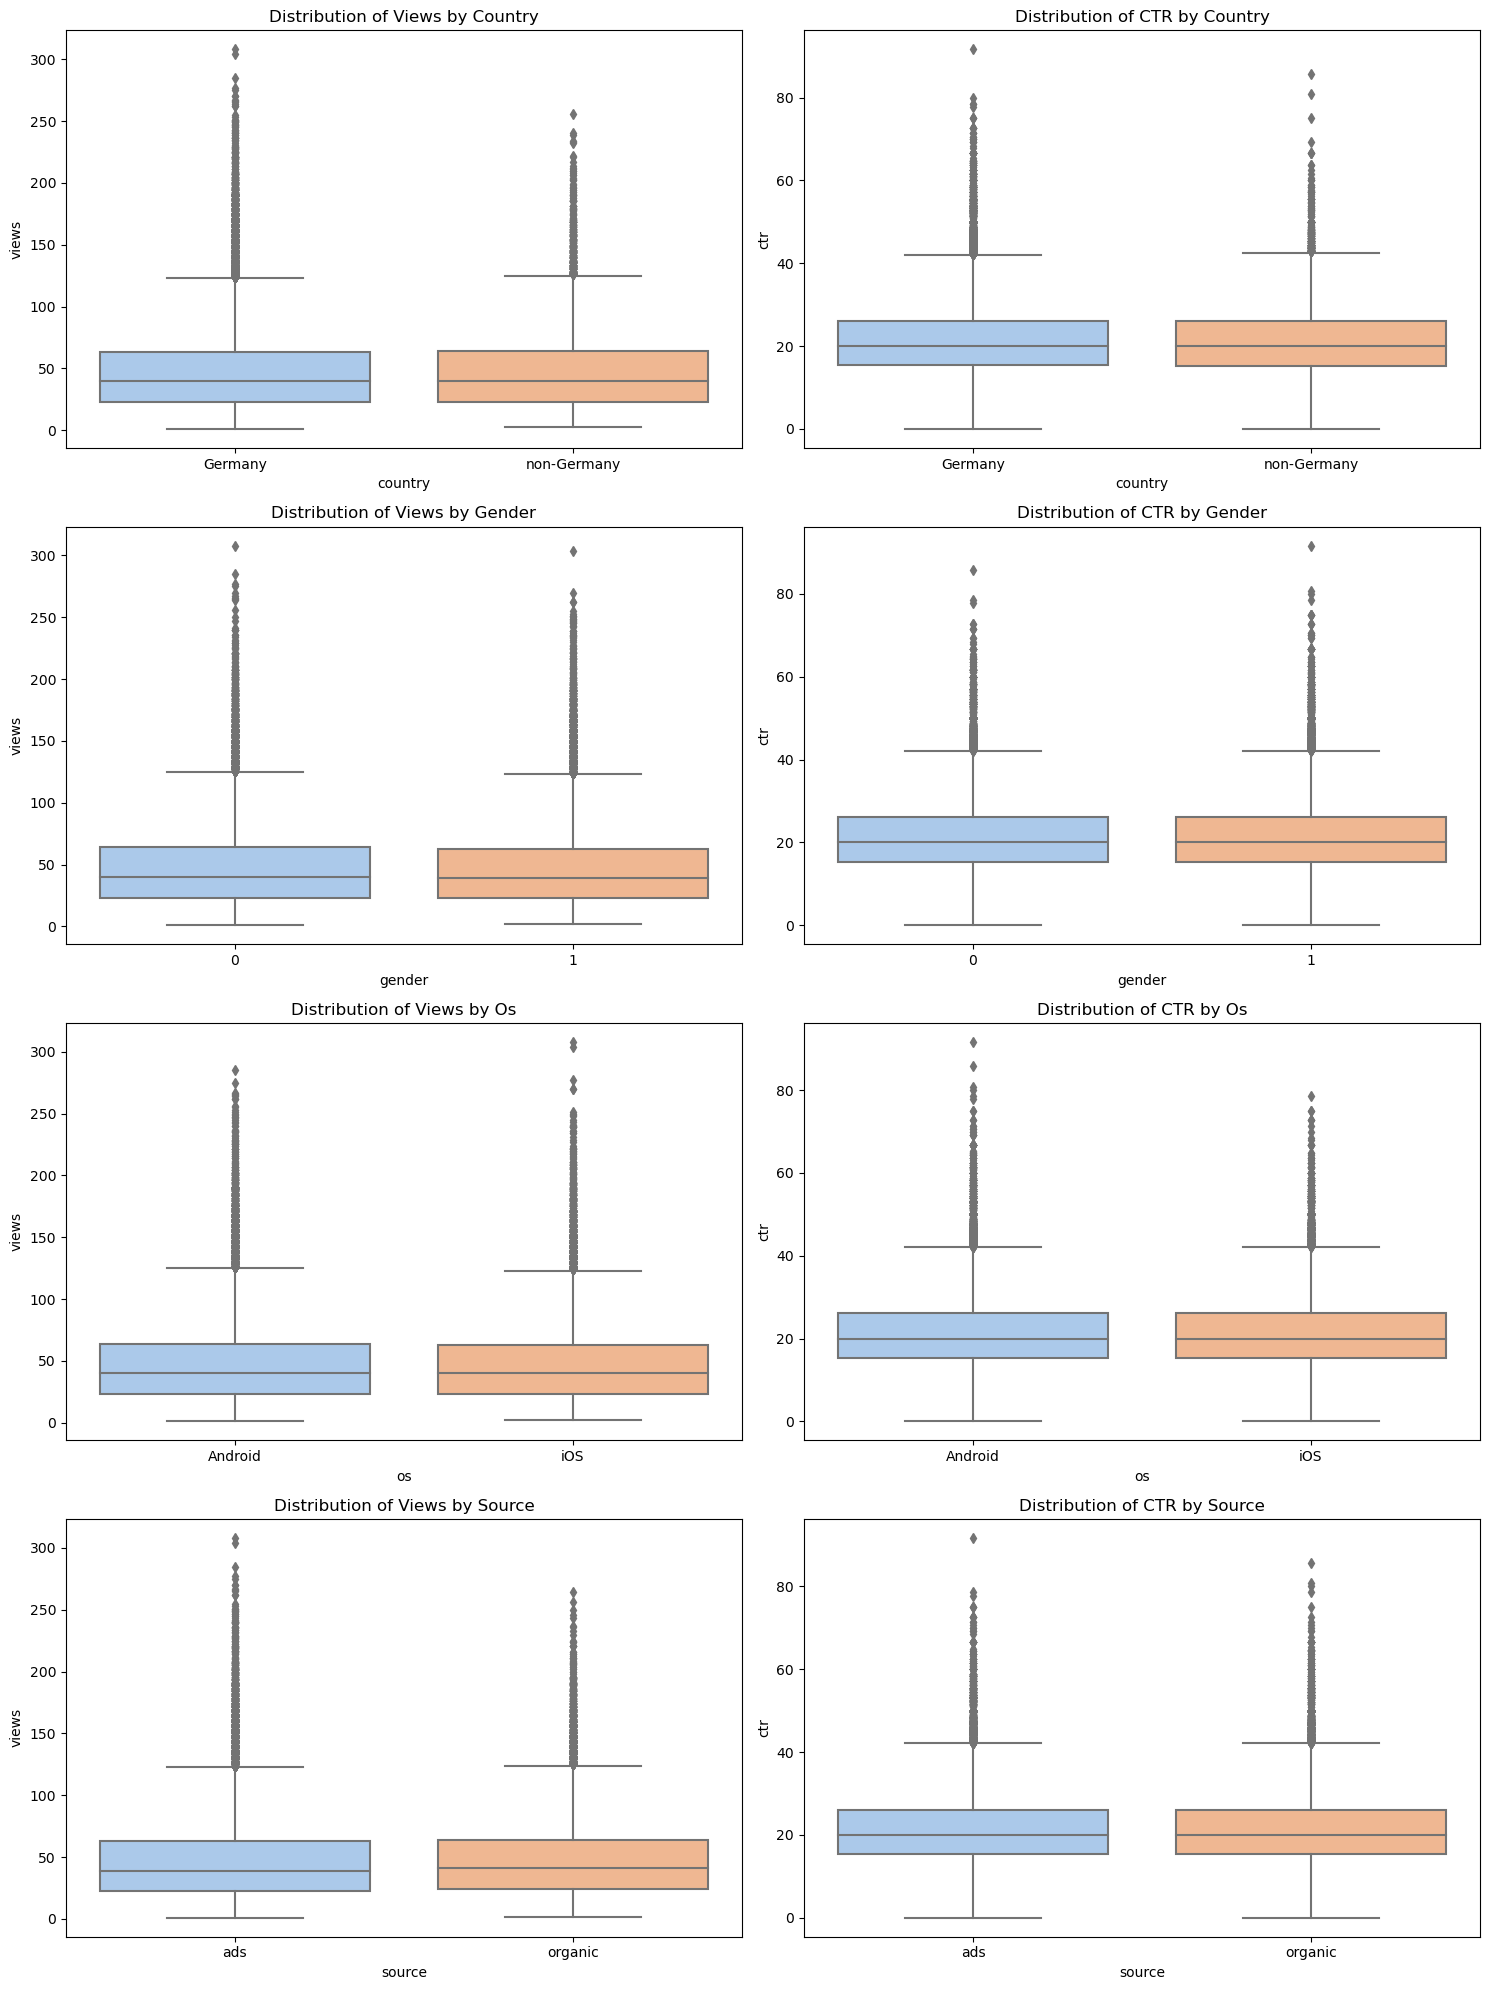

In [23]:
# Attributes to be plotted
attributes = ['country', 'gender', 'os', 'source']

# Setting the figure size
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

# Looping through the attributes to plot
for i, attribute in enumerate(attributes):
    sns.boxplot(data=user_eda_df, x=attribute, y='views', ax=axes[i, 0], palette='pastel')
    axes[i, 0].set_title(f'Distribution of Views by {attribute.capitalize()}')
    
    sns.boxplot(data=user_eda_df, x=attribute, y='ctr', ax=axes[i, 1], palette='pastel')
    axes[i, 1].set_title(f'Distribution of CTR by {attribute.capitalize()}')

plt.tight_layout()

- Most of the metrics seem to be similar (apart from a few outliers) between the groups compared.  

- Interestingly, however, source of the users brings the biggest difference in views per user and user CTR: organic-sourced users tend to watch more posts, yet their CTR is slightly less spread to high values than ad-sourced feed users.  
- It may reflect an obvious observation that ad-sourced traffic has worse quality in general.  
- We can manage our ad channels and monitor the user engagement for the groups to increase, if possible, the quality of the traffic.

## 5. Correlation analysis

- Here, let's investigate the correlation between users age and their engagement level for two groups: ads- and organic-sourced users.  

- For the engagement metric, let's use CTR - it is easier to interpret in terms of the revenue.

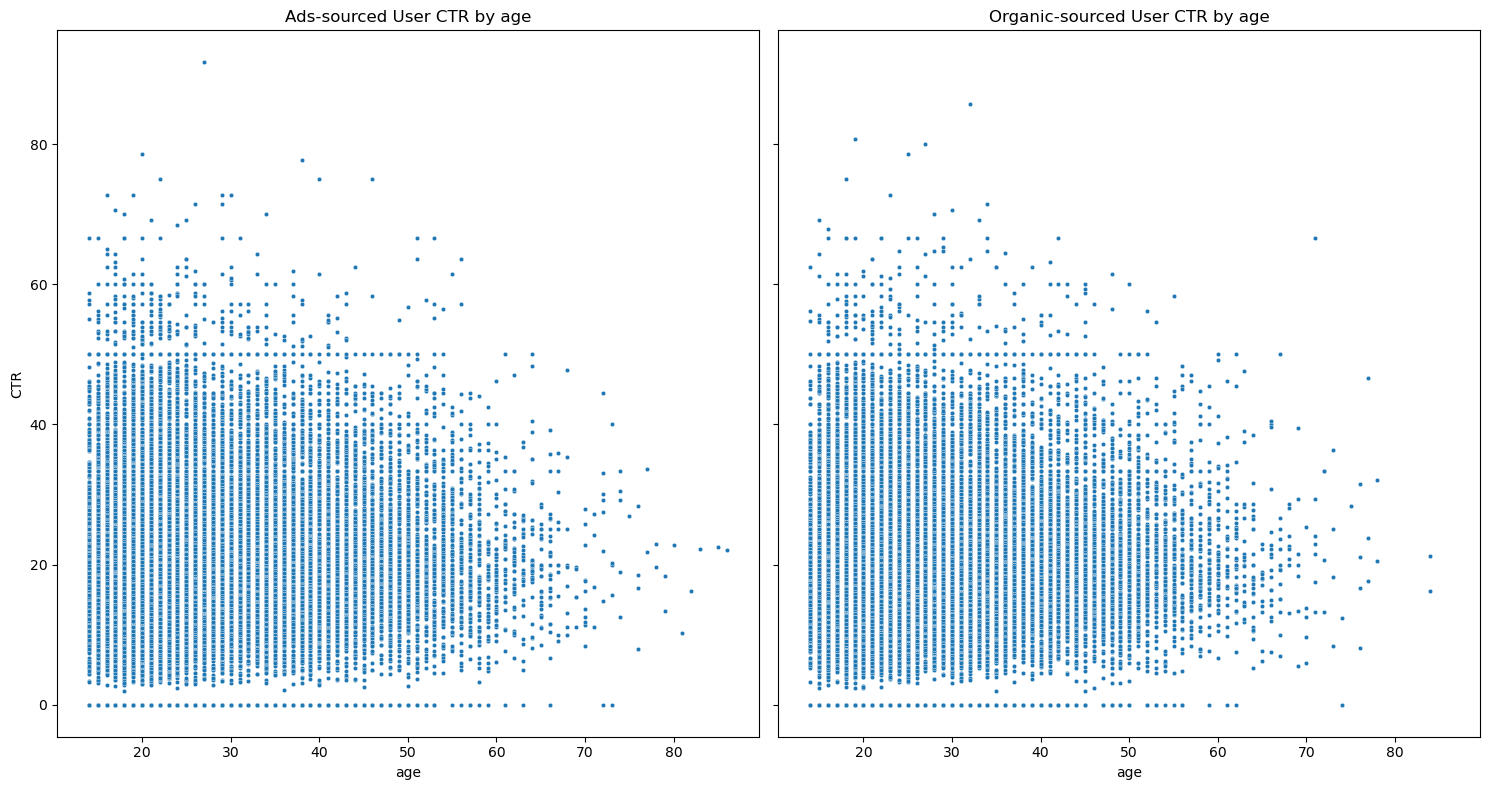

In [24]:
# make filter masks for users based on their source
ads_mask = user_eda_df['source'] == 'ads'
organic_mask = user_eda_df['source'] != 'ads'
masks = [ads_mask, organic_mask]

# titles to use for plotting
titles = [
    'Ads-sourced User CTR by age',
    'Organic-sourced User CTR by age'
]

# make a canvas
fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)

# plot two scatters and annotate them
for mask, title, ax in zip(masks, titles, axes):
    sns.scatterplot(
                data=user_eda_df[mask], 
                x='age', 
                y='ctr', 
                s=10,
                ax=ax
            ) # create the scatter

    ax.set_title(title)
    ax.set_ylabel('CTR')

plt.tight_layout()

1. As we can see, with age increasing CTR distribution is getting quite narrow, localized more towards low CTR values compared to younger groups. We can try targeting this subgroup (40+) with more relevant posts, seeing if it inreases upper CTR interval.  

2. There is not much of a difference in ads vs organic traffic, with CTR lower and upper limits rising/dropping slightly less steep with age in ads-sourced users.

### 6. Time series analysis

- **Daily Activity**: Analyze Daily Active Users (DAU) and the distribution of unique posts throughout a day.

- **Hourly Trends**: Decompose time series to uncover hourly DAU trends and seasonality.
- **User Activity vs. Posts**: Compare the distributions of user activity and posts published within a given day.

Now to the dynamics - let's see how the metrics change in time and which components they have.  
First we start with an overview of the metrics - Daily Active Users (DAU) and daily viewed unique posts.

In [25]:
# SQL Query for daily metrics:
# 1. Group data by day
# 2. Count unique users and unique post views per day
# 3. Exclude the current day

query = '''
    SELECT 
        toStartOfDay(time) AS day,
        count(DISTINCT user_id) AS counted_users,
        count(DISTINCT post_id) AS counted_posts
    FROM simulator_20230720.feed_actions 
    WHERE toStartOfDay(time) != today()
    GROUP BY day
    ORDER BY day
'''

# Import query results into a DataFrame and display top rows
daily_metrics = ph.read_clickhouse(query, connection=connection)
daily_metrics.head()


,day,counted_users,counted_posts
0,2023-06-03,878,89
1,2023-06-04,2238,178
2,2023-06-05,3105,191
3,2023-06-06,3721,211
4,2023-06-07,4617,214


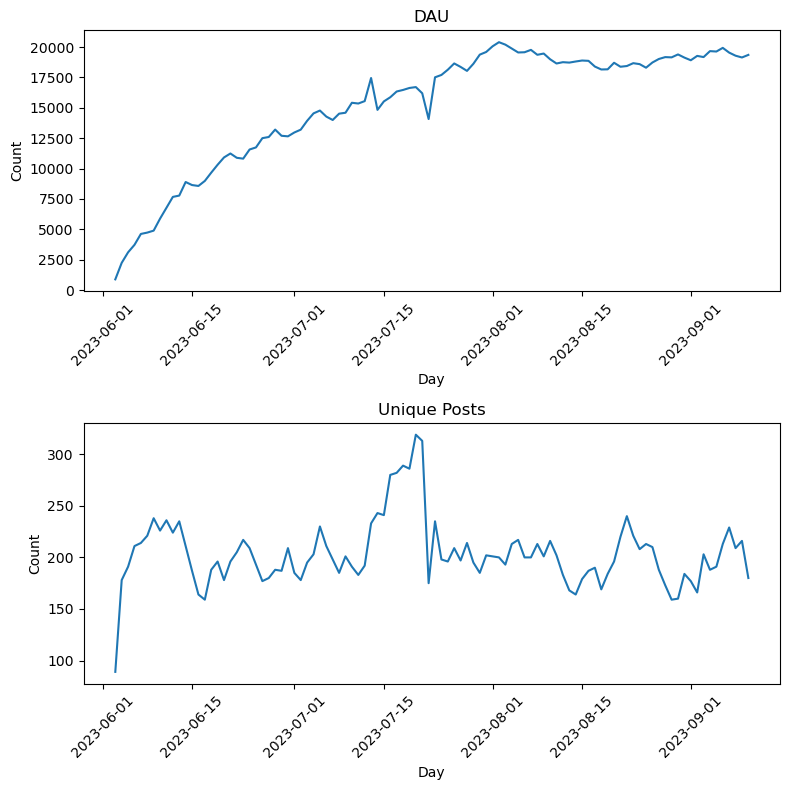

In [26]:
# List of metrics and their respective titles
Y = ['counted_users', 'counted_posts']
titles = ['DAU', 'Unique Posts']

# Create a canvas with 2 subplots (one for each metric)
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Loop over metrics and titles to plot each series
for metric, title, ax in zip(Y, titles, axs):
    sns.lineplot(data=daily_metrics, x='day', y=metric, ax=ax)
    ax.set_ylabel('Count')
    ax.set_xlabel('Day')
    ax.set_title(title)
    
    # Adjust x-axis ticks for readability
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Adjust layout for better visualization
plt.tight_layout()


1. The metrics follow similar trends - initial increase with further saturation. Unique posts reached the plateu much faster than DAU.

2. DAU behaviour is more stable, whilst posts had periods of significant jumps in value.
3. The series appear to have seasonality (could be weekly seasonality).

To test for the last assumption (weekly seasonality), let's take daily posts and decompose the series.

In [27]:
# Define a function to plot the decomposition results from statsmodels' STL
def decompose_plotter(decomposed_obj, figsize=(9, 7)):
    """
    Plot the results of statsmodels' STL decomposition in a structured manner.

    Parameters:
    - decomposed_obj: Object returned by STL decomposition
    - figsize: Tuple indicating the figure size
    """
    fig = decomposed_obj.plot()  # Get the plot figure from the decomposed object
    
    # Enhance the residuals' markers for better visibility
    fig.axes[3].lines[0].set(markersize=3)
    
    # Adjust the figure size
    fig.set_size_inches(figsize)
    
    # Adjust layout for better visualization
    fig.tight_layout()

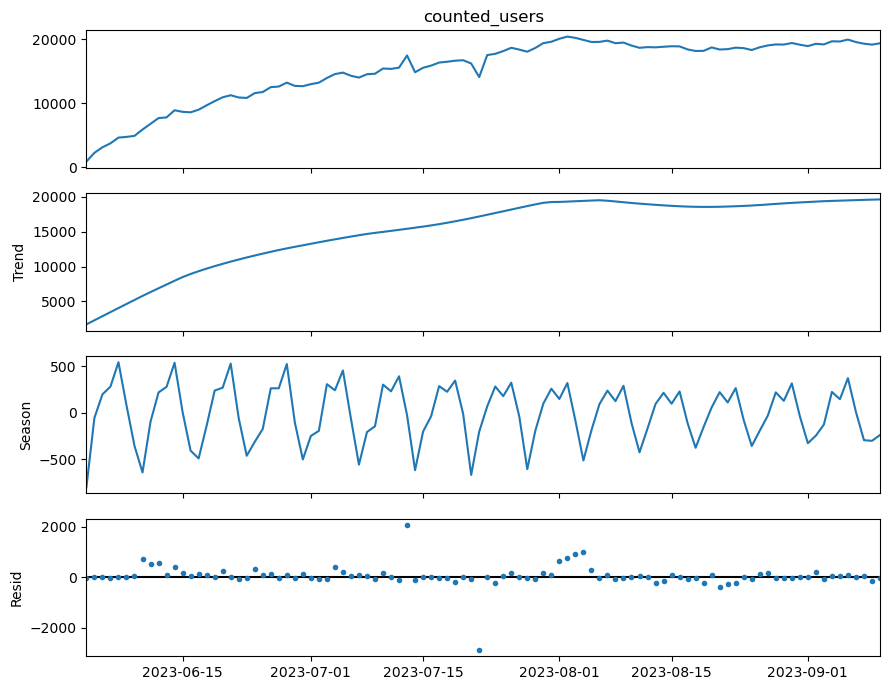

In [28]:
# Decompose the 'counted_users' metric using STL with a robust setting
res = STL(daily_metrics.set_index('day')['counted_users'], robust=True).fit()

# Use the defined function to plot the decomposition results
decompose_plotter(res)

Indeed, there seems to be a slight 7-day seasonality. 

Next, let's decompose hourly active users time series into the components using STL decomposition.

In [29]:
# SQL Query to group data by hour and count unique users:
query = '''
    SELECT 
        toStartOfHour(time) AS hour,
        COUNT(DISTINCT user_id) AS counted_users
    FROM simulator_20230720.feed_actions 
    GROUP BY hour
    ORDER BY hour
'''

# Import the query results into a DataFrame
hourly_users = ph.read_clickhouse(query, connection=connection)

# Display the top rows of the DataFrame
hourly_users.head()


,hour,counted_users
0,2023-06-03 00:00:00,14
1,2023-06-03 01:00:00,26
2,2023-06-03 02:00:00,16
3,2023-06-03 03:00:00,11
4,2023-06-03 04:00:00,14


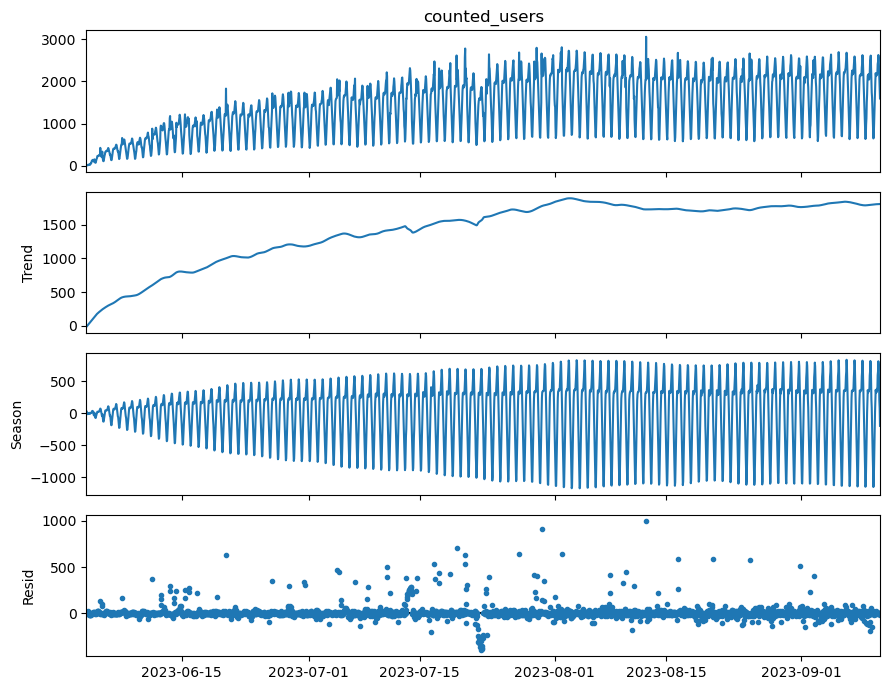

In [30]:
# Decompose the 'counted_users' metric on an hourly basis using STL
res = STL(hourly_users.set_index('hour')['counted_users'], robust=True).fit()

# Plot the decomposition results using the previously defined function
decompose_plotter(res)

- The metric has 24-hr seasonality, yet the trend is not exactly smooth, indicating either noise or additional seasonality (e.g. 7-days) in the series.
 
- The knowledge of 24-hr seasonality, together with 7-days seasonality, can be used in further forecasting applications to enhance prediction power.

Now to the last step of this EDA - let's see for each hour of a day (0-23), how many unique users we have and how many posts are published on average. At a posting time, let's use the first 'view' time of a given post.

In [31]:
# SQL Query to derive the number of users and posts per hour:
# 1. Extract unique users by hour
# 2. Determine the hour of the first action per post (essentially publishing hour)
# 3. Aggregate posts by their start hour
# 4. Left join user and post stats by hour

query = '''
WITH 
    unique_users_start_hour AS (
        SELECT 
            toStartOfHour(time) AS hour,
            COUNT(DISTINCT user_id) AS counted_users
        FROM simulator_20230720.feed_actions 
        GROUP BY hour
    ),
    
    post_start_hour AS (
        SELECT 
            toStartOfHour(min(time)) AS hour, 
            post_id
        FROM simulator_20230720.feed_actions
        GROUP BY post_id
    ),
    
    postings_start_hour AS (
        SELECT
            hour,
            COUNT(DISTINCT post_id) AS counted_posts
        FROM post_start_hour
        GROUP BY hour
    )

SELECT
    toHour(hour) AS hour_of_day,
    AVG(counted_users) AS users_count,
    AVG(counted_posts) AS posts_count
FROM
    unique_users_start_hour
LEFT JOIN postings_start_hour
    ON unique_users_start_hour.hour = postings_start_hour.hour
GROUP BY hour_of_day
'''

# Import the query results into a DataFrame and display the top rows
df_posting_activity = ph.read_clickhouse(query, connection=connection)
df_posting_activity.head()

,hour_of_day,users_count,posts_count
0,0,1106.29,3.16
1,1,914.55,0.64
2,2,716.61,0.09
3,3,523.46,0.00
4,4,543.45,0.00


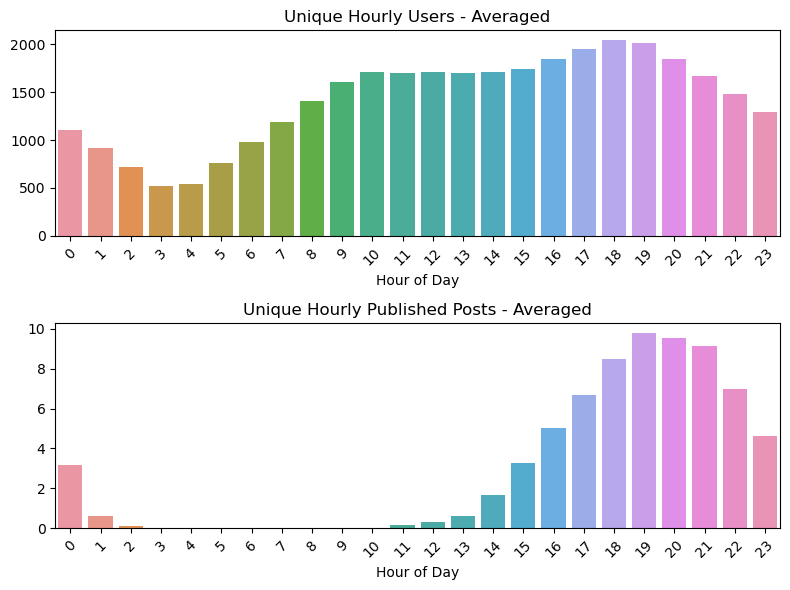

In [32]:
# Set up the figure and subplots for plotting
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Metrics and corresponding titles for the subplots
Y = ['users_count', 'posts_count']
titles = ['Unique Hourly Users - Averaged', 'Unique Hourly Published Posts - Averaged']

# Plot the data for each metric
for ax, y, title in zip(axes, Y, titles):
    sns.barplot(data=df_posting_activity, x='hour_of_day', y=y, ax=ax)
    ax.set_title(title)              # Set subplot title
    ax.set_ylabel('')                # Remove the y-axis label for clarity
    ax.set_xlabel('Hour of Day')     # Label x-axis
    
    # Set and rotate the x-axis tick labels for better readability
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Adjust subplot spacing
plt.tight_layout()

- From 3 to 8 AM no posts are published - radiosilence. 

- Posts are peaking at 9 PM, which is one hour after users peaking (6 PM).

Knowing this is helpful for a) planning server workloads based on hour of a day (maintanence work, high-load API calls schedule) and b) planning ad-campaigns based on the time.


### 7. Conclusions

- Majority of the feed users are between 20-35 years old, with 2/3 using Android app and 60% coming via paid traffic.

- Germany has the majority of the users, and Poland, Belarus, Kazakhstan forming the most of non-German traffic.
- Posts having highest number of views tend to have higher conversions, we can try promotng posts with slightly lower views to increase their CTR.
- Posts 'live' 1-3 days on average, and long-living posts (>5 days) have higher CTR. Similarly, we can promote posts with 3-4 days life to get higher conversions.
- Organic traffic has higher per-user views than the paid one (100-200 VS 50-150 for 50% of users).
- DAU has both 24-hr and 7-day seasonality.
- Active users is peaking at 6-7 PM, with post published peaking at 7-8 PM. Lowest activity is observed for 1-5 AM.

